<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK27_case2_Kaggle_ML_Classification_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제 : 사기/정상 거래를 구분하기 위한 모델을 수립
```
Label name : Class - 1(사기) or 0(정상 사용자)
```
보안 상의 문제로 데이터는 scaled 되어있음. 또한 feature name이 정보를 유추할 
수 없게 코드화되어있음. <br>
이 프로젝트는 다섯 가지 목표를 가지고 있음.<br>
```
1. 주어진 데이터셋 분포를 확인
2. NearMiss Algorithm을 이용해, 사기/정상 거래 비율이 50:50인 sub-dataframe 생성
3. 높은 정확도를 갖는 Classifier 결정
4. Neural Network 활용 - best classifier와 성능(정확도) 비교
5. 불균등 데이터셋(Imbalanced data)에서 저지를 수 있는 실수에 대해 이해
```

단, 3/4번 목표와 관련하여, 본 문제는 Class간에 분포가 편향된 imbalanced data 문제로, 성능 지표로 정확도를 활용하는 것은 의미가 떨어지므로 Area Under the Precision-Recall Curve (AUPRC)를 활용하기로 함. <BR>
[Kaggle 노트북 출처](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook)

[Credit Card Fraud Detection - 문제 상황 이해](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html)

# 1. 필요한 라이브러리 및 데이터 불러오기 

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings 
warnings.filterwarnings('ignore')


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
df = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/creditcard.csv/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. 데이터 전처리(Preprocessing)
1. Scaling and distributing
2. Splitting

In [52]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [53]:
df.isnull().sum().sum()

0

In [54]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

위 기초정보 확인을 통해 다음 세 가지를 확인함<bR>
1. 거래 비용이 상대적으로 낮음 - 평균 거래 비용 = $88
2. 결측치 없음 
3. 정상거래(99.83%) 대비 사기거래(0.17%) 비율 매우 낮음 

특히 3번에 대해, 별다른 조치 없이 skewed/imbalanced data를 그대로 이용해 사기/정상 거래 여부를 예측해준다면, 우리 알고리즘은 **대부분의 거래를 정상거래로 간주**한 상태에서 작동할 것.<br>
따라서 overfitting을 방지하고, 모델이 사기/정상거래 Class를 구분할 신호를 감지할 수 있도록 전처리와 Resampling을 진행해줄 것임

Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1 : Fraud)')

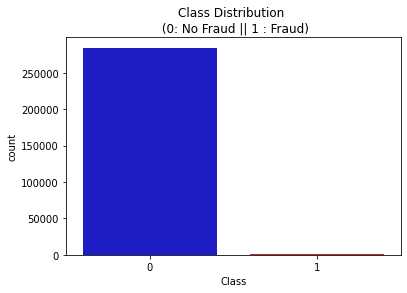

In [55]:
colors = ["#0101DF", "#DF0101"]
_ = sns.countplot(data = df, x = 'Class', palette = colors)
plt.title('Class Distribution \n (0: No Fraud || 1 : Fraud)')

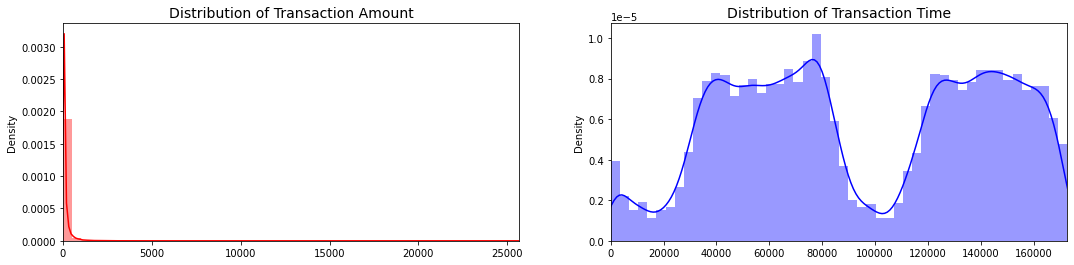

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax = ax[0], color = 'r')
ax[0].set_title('Distribution of Transaction Amount', fontsize =14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax = ax[1], color = 'b')
ax[1].set_title('Distribution of Transaction Time', fontsize =14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

위의 기술통계 dataframe을 보면, V1~V28 다른 컬럼들은 평균값이 e-16 수준으로 매우 작게 scale되어 있음을 알 수 있음.<br>
따라서 Time / Amount 컬럼 역시 여타 컬럼과 비슷하게 scale, distribute를 해줘야함을 알 수 있다.

Sub-sample (사기거래 vs 정상거래 비율이 50:50으로 동등하게 구성된) 생성 필요<br>
만약 심하게 치우친 원본 데이터를 그대로 사용할 경우, 아래와 같은 문제를 직면할 수 있음<br>
1. Overfitting - 대부분의 케이스가 정상 거래라고 가정하고 예측할 수 있음<br>
2. 왜곡된 상관관계 - 보안 문제로 V features가 의미하는 정확한 내용은 모르지만, feature - label variable 간 상관관계를 확인하는 건 예측이 도움이 될 수 있음<br> 이 때 편향된 데이터를 분석하면 정확한 상관관계의 본질을 못 볼 수 있음

## 2.1. Scaling and distributing

In [57]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# RobustScaler : 이상치에 더 강함(less prone to outliers)
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) # df['Amount'].values : array in shape of (284807,) --> reshape(-1,1) --> shape of (284807,1)
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount', 'Time'], axis = 1, inplace = True)

reshape()에서 -1은 기존의 행열 사이즈를 참조한다는 뜻임. <br>
예를 들어, 3 * 4 행렬을 reshape(-1,1) 하면 12 * 1 / reshape(-1,4) 하면 결과적으로 3 * 4의 행렬이 되는거임

In [58]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis = 1, inplace = True)
# scale Amount and Time
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'saled_time', scaled_time)

df.head()

,scaled_amount,saled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


df.insert(loc, column, value)<br>
데이터 프레임의 지정된 위치에, 컬럼을 넣어줌.<br>
이 때 동일한 컬럼이 데이터프레임에 존재할 경우, allow_duplicates 를 어떤 값으로 설정하던 간에 ValueError가 발생함. .<br>따라서 먼저 해당 컬럼 다른 변수에 저장 > 삭제 후 > insert 해준거임

## 2.2. Splitting

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Fraunds', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Fraunds', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

No Fraunds 99.83 % of the dataset
Fraunds 0.17 % of the dataset


In [60]:
X = df.drop('Class', axis =1)
y = df['Class']

In [61]:
sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

for train_index, test_index in sss.split(X, y):
    print('Train: ', train_index, 'Test: ', test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


Train:  [ 30473  30496  31002 ... 284804 284805 284806] Test:  [    0     1     2 ... 57017 57018 57019]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [ 30473  30496  31002 ... 113964 113965 113966]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [ 81609  82400  83053 ... 170946 170947 170948]
Train:  [     0      1      2 ... 284804 284805 284806] Test:  [150654 150660 150661 ... 227866 227867 227868]
Train:  [     0      1      2 ... 227866 227867 227868] Test:  [212516 212644 213092 ... 284804 284805 284806]


In [62]:
type(original_Xtrain), type(original_Xtrain.values)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [63]:
# array 형태로 바꿔줌
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [64]:
# train, test 동등한 비율로 분리되었는지 확인해줌
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)

print('Label distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

Label distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


StratifiedKFold.split(X, y, groups=None)<br>
Generate indices to split data into training and test set.

# 3. Random Undersampling and Oversampling
1. Distributing and Correlating
2. Anomaly Detection
3. Dimensionality Reduction and Clustering (t-SNE)
4. Classifiers
5. A Deeper Look into Logistic Regression
6. Oversampling with SMOTE

In [65]:
len(df.loc[df.Class == 1])

492

In [66]:
df = df.sample(frac = 1)

# fraud samples
fraud_df = df.loc[df['Class']==1]
# non-fraud samples
non_fraud_df = df.loc[df['Class']==0][:492] # 사기:정상 비율이 50:50인 subsample 만들어주기 위함임

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [67]:
new_df = normal_distributed_df.sample(frac = 1, random_state = 42)
new_df.head()

,scaled_amount,saled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
204265,0.097673,0.593334,-0.919351,0.708193,1.485684,-0.924825,0.607483,-0.121714,0.531013,0.137214,...,0.060965,0.153460,0.441802,-0.433001,0.644960,0.695587,0.623164,-0.010298,0.083470,0
79525,-0.293440,-0.312880,-2.630598,5.125759,-6.092255,5.527393,1.605145,-2.319884,-3.207076,-1.482583,...,0.948864,-0.527474,0.220546,-1.371110,-0.504899,0.382307,0.395528,0.782036,0.628528,1
212449,-0.028086,0.636368,-4.201090,2.035542,-0.196243,-0.491993,-1.005945,0.048531,-1.805465,-2.806161,...,-1.458715,3.317027,-1.699884,1.139303,-0.171724,0.097843,0.106771,0.686533,-0.218870,0
6331,-0.293440,-0.906566,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,...,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1
151007,-0.293440,0.113606,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1


위에서 만들어준 correctly balanced dataset을 가지고, 전처리/분석 진행해줄것임

## 3.1. Distributing and Correlating

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


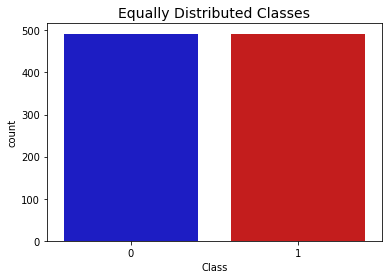

In [68]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

_ = sns.countplot(data = new_df, x = 'Class', palette = colors)
plt.title('Equally Distributed Classes', fontsize = 14)
plt.show()

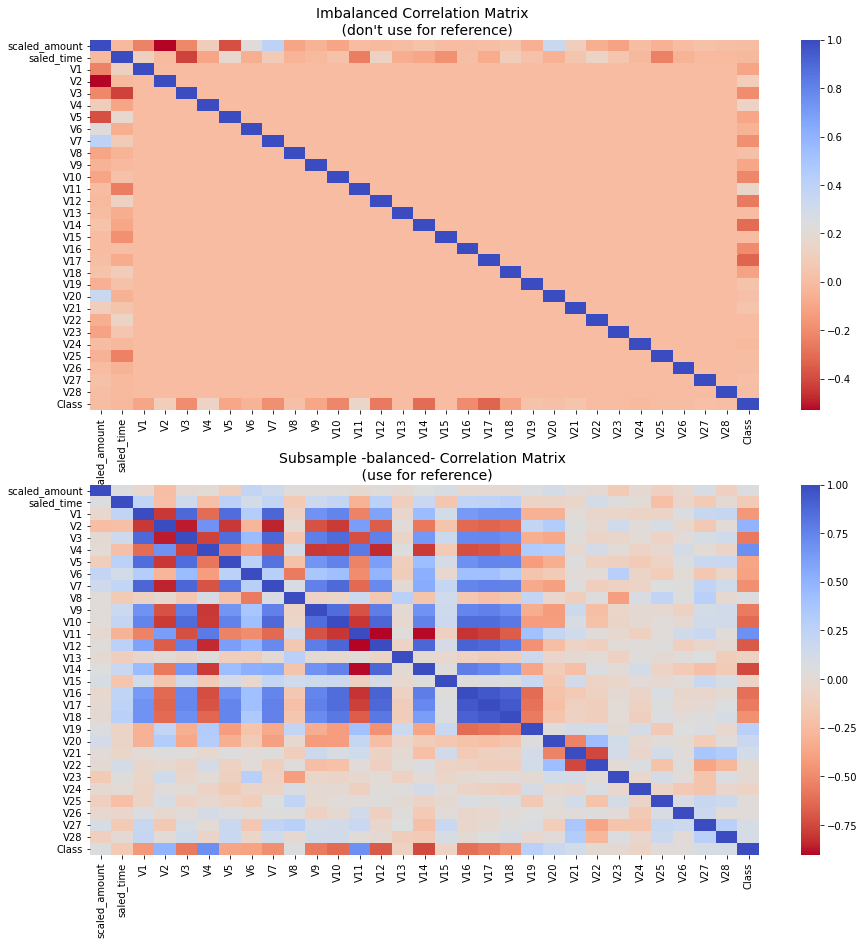

In [69]:
# correlation : 반드시 balanced dataset 사용하도록 주의! 
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))

# 원본 데이터셋 correlation table
corr = df.corr()
_= sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size':20}, ax = ax1)
ax1.set_title('Imbalanced Correlation Matrix \n (don\'t use for reference)', fontsize = 14)

# Balanced 데이터셋 correlation table
sub_sample_corr = new_df.corr()
_= sns.heatmap(sub_sample_corr, cmap = 'coolwarm_r', annot_kws = {'size':20}, ax = ax2,)
ax2.set_title('Subsample -balanced- Correlation Matrix \n (use for reference)', fontsize = 14)

plt.show()

In [70]:
features_neg_corr = sub_sample_corr[sub_sample_corr['Class'] <= -0.5].index.tolist()
features_pos_corr = sub_sample_corr[(sub_sample_corr['Class'] >= 0.5) & (sub_sample_corr['Class']<1)].index.tolist()

len(features_neg_corr), len(features_pos_corr)

(7, 3)

In [71]:
print(features_neg_corr)
print(features_pos_corr)

['V3', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17']
['V2', 'V4', 'V11']


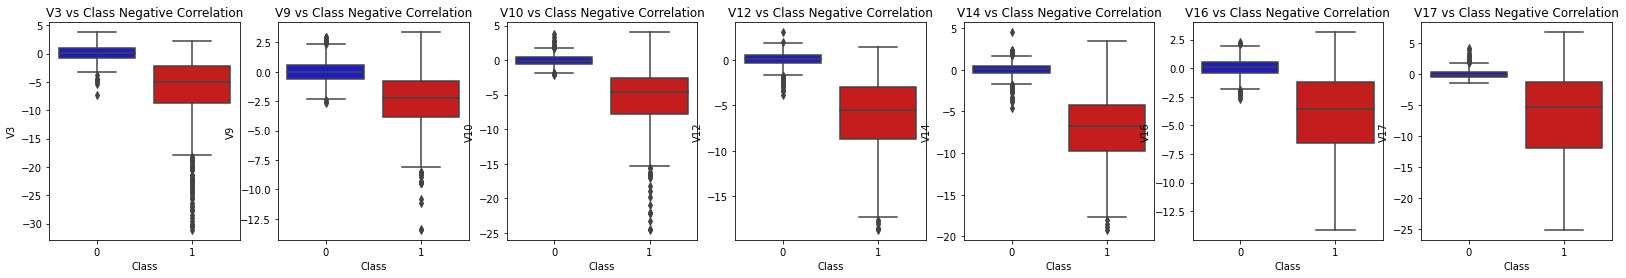

In [72]:
# boxplots
f, axes = plt.subplots(ncols = len(features_neg_corr), figsize = (28, 4))

# 음의 상관관계 갖는 피쳐들
sns.boxplot(x="Class", y="V3", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V3 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V9", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V9 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[4])
axes[4].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[5])
axes[5].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[6])
axes[6].set_title('V17 vs Class Negative Correlation')

plt.show()


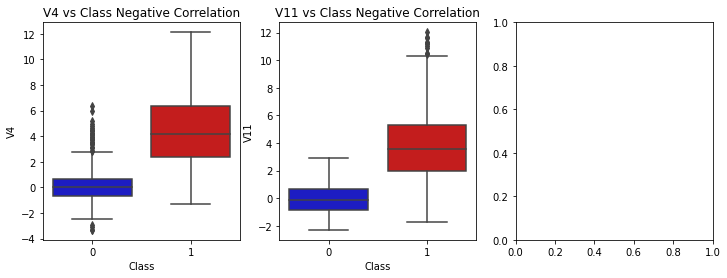

In [73]:
# boxplots
f, axes = plt.subplots(ncols = len(features_pos_corr), figsize = (12, 4))

# 양의 상관관계 갖는 피쳐들
sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V4 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V11 vs Class Negative Correlation')

plt.show()


## 3.2. Anomaly Detection

In [74]:
features_neg_corr

['V3', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17']

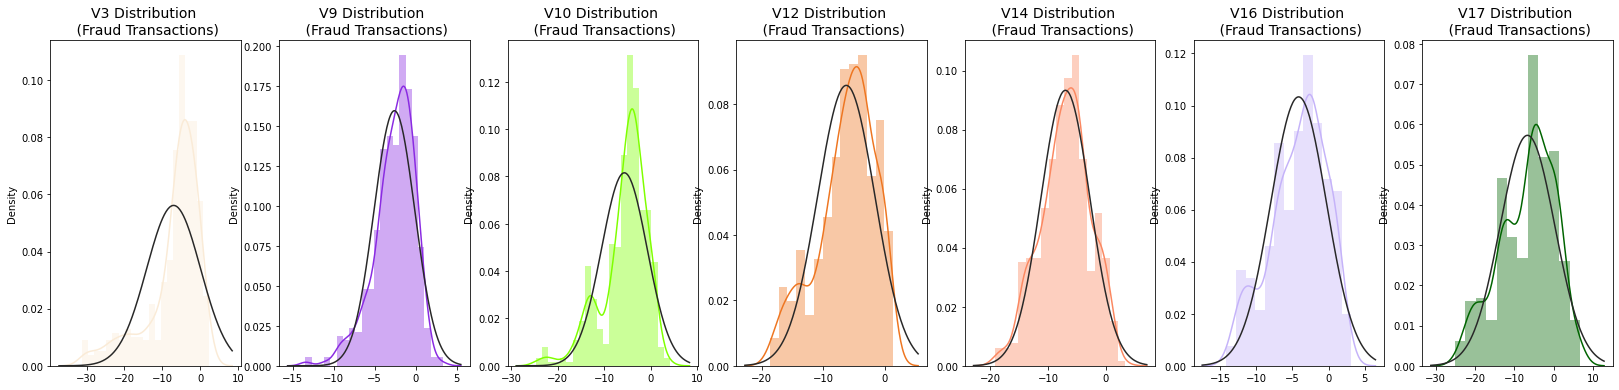

In [75]:
# 분포 확인
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,len(features_neg_corr), figsize=(28, 6))

V3_fraud_dist = new_df['V3'].loc[new_df['Class'] == 1].values
sns.distplot(V3_fraud_dist,ax=ax1, fit=norm, color='#FAEBD7')
ax1.set_title('V3 Distribution \n (Fraud Transactions)', fontsize=14)

V9_fraud_dist = new_df['V9'].loc[new_df['Class'] == 1].values
sns.distplot(V9_fraud_dist,ax=ax2, fit=norm, color='#8A2BE2')
ax2.set_title('V9 Distribution \n (Fraud Transactions)', fontsize=14)

V10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(V10_fraud_dist,ax=ax3, fit=norm, color='#7FFF00')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

V12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(V12_fraud_dist,ax=ax4, fit=norm, color='#EE7621')
ax4.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

V14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(V14_fraud_dist,ax=ax5, fit=norm, color='#FB8861')
ax5.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

V16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(V16_fraud_dist,ax=ax6, fit=norm, color='#C5B3F9')
ax6.set_title('V16 Distribution \n (Fraud Transactions)', fontsize=14)

V17_fraud_dist = new_df['V17'].loc[new_df['Class'] == 1].values
sns.distplot(V17_fraud_dist,ax=ax7, fit=norm, color='#006400')
ax7.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

위 그래프를 보면, feature V14가 다른 피쳐에 비해 정규분포에 가까운 분포를 보임을 알 수 있음

In [76]:
# Outlier 제거

# V14
v14_fraud = new_df['V14'].loc[new_df['Class']==1].values
if v14_fraud.shape[0] > 0 :
    q25 = np.percentile(v14_fraud, 25)
    q75 = np.percentile(v14_fraud, 75)
    print('Quantile 25: {} | Quantile 75 : {}'.format(q25, q75))
    v14_iqr = q75 - q25
    print('IQR: {}'.format(v14_iqr))

    v14_cut_off = v14_iqr * 1.5
    v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
    print('Cut Off: {}'.format(v14_cut_off))
    print('V14 Lower: {}'.format(v14_lower))
    print('V14 Upper: {}'.format(v14_upper))

    outliers = [x for x in v14_fraud if ((x < v14_lower) or (x > v14_upper))]
    print('Feature V14 Outliers for Fraud cases: {}'.format(len(outliers)))
    print('V14 Outliers: {}'.format(outliers))

    new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))
    print('----' * 44)


# V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values

if v12_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
    v12_iqr = q75 - q25
    v12_cut_off = v12_iqr * 1.5
    v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
    print('V12 Lower: {}'.format(v12_lower))
    print('V12 Upper: {}'.format(v12_upper))
    outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
    print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
    print('V12 outliers: {}'.format(outliers))
    new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))
    print('----' * 44)


# V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values

if v10_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
    v10_iqr = q75 - q25
    v10_cut_off = v10_iqr * 1.5
    v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
    print('V10 Lower: {}'.format(v10_lower))
    print('V10 Upper: {}'.format(v10_upper))
    outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
    print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
    print('V10 outliers: {}'.format(outliers))
    new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))
    print('----' * 44)

# V16
v16_fraud = new_df['V16'].loc[new_df['Class']==1].values

if v16_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
    print('Quantile 25: {} | Quantile 75 : {}'.format(q25, q75))
    v16_iqr = q75 - q25
    print('IQR: {}'.format(v16_iqr))
    v16_cut_off = v16_iqr * 1.5
    v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
    print('Cut Off: {}'.format(v16_cut_off))
    print('V16 Lower: {}'.format(v16_lower))
    print('V16 Upper: {}'.format(v16_upper))
    outliers = [x for x in v16_fraud if x < v16_lower or x > v16_upper]
    print('Feature V16 Outliers for Fraud cases: {}'.format(len(outliers)))
    print('V16 Outliers: {}'.format(outliers))
    new_df = new_df.drop(new_df[(new_df['V16'] > v16_upper) | (new_df['V16'] < v16_lower)].index)
    print('----' * 44)


# V17
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values

if v17_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
    v17_iqr = q75 - q25
    v17_cut_off = v17_iqr * 1.5
    v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
    print('V17 Lower: {}'.format(v17_lower))
    print('V17 Upper: {}'.format(v17_upper))
    outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
    print('V17 outliers: {}'.format(outliers))
    print('Feature V17 Outliers for Fraud Cases: {}'.format(len(outliers)))
    new_df = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))
    print('----' * 44)


# V9
v9_fraud = new_df['V9'].loc[new_df['Class'] == 1].values

if v9_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v9_fraud, 25), np.percentile(v9_fraud, 75)
    v9_iqr = q75 - q25
    v9_cut_off = v9_iqr * 1.5
    v9_lower, v9_upper = q25 - v9_cut_off, q75 + v9_cut_off
    print('V9 Lower: {}'.format(v9_lower))
    print('V9 Upper: {}'.format(v9_upper))
    outliers = [x for x in v9_fraud if x < v9_lower or x > v9_upper]
    print('V9 outliers: {}'.format(outliers))
    print('Feature V9 Outliers for Fraud Cases: {}'.format(len(outliers)))
    new_df = new_df.drop(new_df[(new_df['V9'] > v9_upper) | (new_df['V9'] < v9_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))
    print('----' * 44)


# V3
v3_fraud = new_df['V3'].loc[new_df['Class'] == 1].values

if v3_fraud.shape[0] > 0 :
    q25, q75 = np.percentile(v3_fraud, 25), np.percentile(v3_fraud, 75)
    v3_iqr = q75 - q25
    v3_cut_off = v3_iqr * 1.5
    v3_lower, v3_upper = q25 - v3_cut_off, q75 + v3_cut_off
    print('V3 Lower: {}'.format(v3_lower))
    print('V3 Upper: {}'.format(v3_upper))
    outliers = [x for x in v3_fraud if x < v3_lower or x > v3_upper]
    print('V3 outliers: {}'.format(outliers))
    print('Feature V3 Outliers for Fraud Cases: {}'.format(len(outliers)))
    new_df = new_df.drop(new_df[(new_df['V3'] > v3_upper) | (new_df['V3'] < v3_lower)].index)
    print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Quantile 25: -9.692722964972386 | Quantile 75 : -4.282820849486865
IQR: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud cases: 4
V14 Outliers: [-19.2143254902614, -18.8220867423816, -18.4937733551053, -18.0499976898594]
Number of Instances after outliers removal: 979
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
Feature V12 Outliers for Fraud Cases: 4
V12 outliers: [-18.0475965708216, -18.6837146333443, -18.5536970096458, -18.4311310279993]
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958

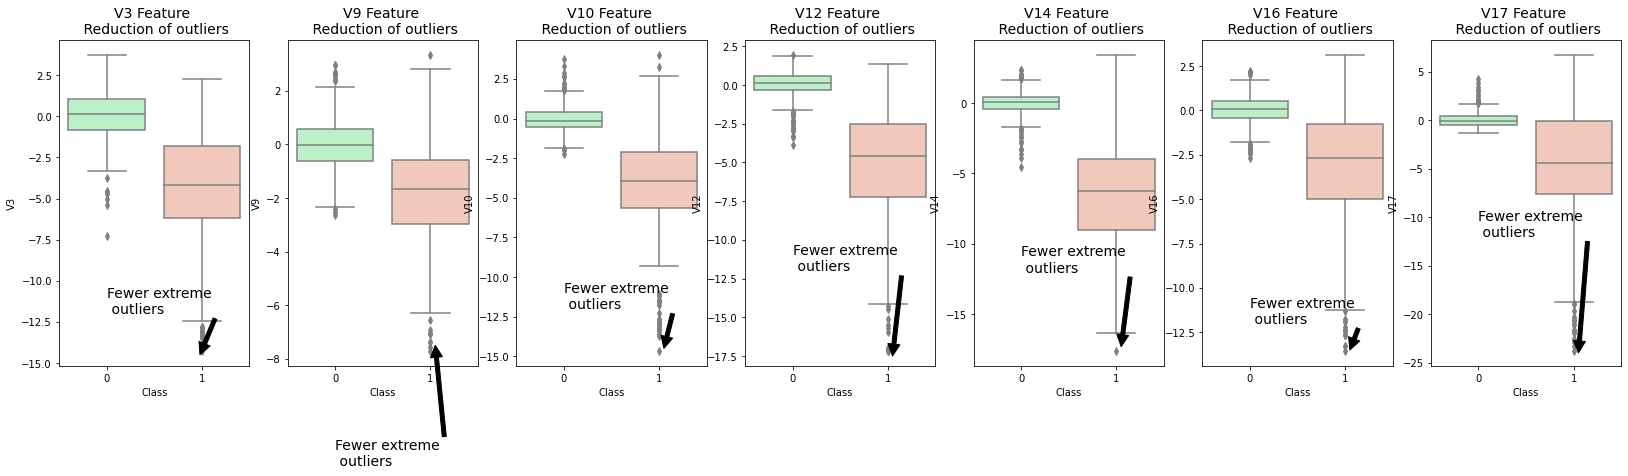

In [77]:
f,ax = plt.subplots(1, 7, figsize=(28,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed

# Feature V3
if len(new_df['V3']) > 0 :
    sns.boxplot(x="Class", y="V3", data=new_df,ax=ax[0], palette=colors)
    ax[0].set_title("V3 Feature \n Reduction of outliers", fontsize=14)
    ax[0].annotate('Fewer extreme \n outliers', xy=(0.98, -14.5), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V9
if len(new_df['V9']) > 0 :
    sns.boxplot(x="Class", y="V9", data=new_df, ax=ax[1], palette=colors)
    ax[1].set_title("V9 Feature \n Reduction of outliers", fontsize=14)
    ax[1].annotate('Fewer extreme \n outliers', xy=(1.05, -7.5), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V10
if len(new_df['V10']) > 0 :
    sns.boxplot(x="Class", y="V10", data=new_df, ax=ax[2], palette=colors)
    ax[2].set_title("V10 Feature \n Reduction of outliers", fontsize=14)
    ax[2].annotate('Fewer extreme \n outliers', xy=(1.05, -14.5), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V12
if len(new_df['V12']) > 0 :
    sns.boxplot(x="Class", y="V12", data=new_df,ax=ax[3], palette=colors)
    ax[3].set_title("V12 Feature \n Reduction of outliers", fontsize=14)
    ax[3].annotate('Fewer extreme \n outliers', xy=(1.05, -17.5), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V14
if len(new_df['V14']) > 0 :
    sns.boxplot(x="Class", y="V14", data=new_df, ax=ax[4], palette=colors)
    ax[4].set_title("V14 Feature \n Reduction of outliers", fontsize=14)
    ax[4].annotate('Fewer extreme \n outliers', xy=(1.05, -17.3), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V16
if len(new_df['V16']) > 0 :
    sns.boxplot(x="Class", y="V16", data=new_df, ax=ax[5], palette=colors)
    ax[5].set_title("V16 Feature \n Reduction of outliers", fontsize=14)
    ax[5].annotate('Fewer extreme \n outliers', xy=(1.05, -13.5), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)

# Feature V17
if len(new_df['V17']) > 0 :
    sns.boxplot(x="Class", y="V17", data=new_df, ax=ax[6], palette=colors)
    ax[6].set_title("V17 Feature \n Reduction of outliers", fontsize=14)
    ax[6].annotate('Fewer extreme \n outliers', xy=(1.05, -24.0), xytext=(0, -12),
                arrowprops=dict(facecolor='black'),
                fontsize=14)


plt.show()

(에러 보고) ValueError: min() arg is an em`pty sequence<BR>
찾아보니 내가 명령한 조건에 해당하는 데이터가 없을 떄 위와 같은 에러를 일으킴<BR>
따라서 해당 샘플이 있을 때만 조건을 수행하도록, len(data) 조건을 넣어주니 에러없이 잘 작동함을 확인
```
if len(new_df['V3']) > 0 :
```


## 3.3. Dimensionality Reduction and Clustering (t-SNE)
[t-SNE 알고리즘, Clearly Explained by Joshua Starmer](https://www.youtube.com/watch?v=NEaUSP4YerM)

관련 개념 간략하게 정리<BR>
1. 차원축소(Dimensionality Reduction) : 머신러닝에서 중요한 feature는 남기고, 불필요한 feature의 갯수를 줄여 overfitting을 방지하는 것.<BR>
그 방법으로는 다음 세 가지가 있음<BR>
    - feature elimination
    - feature selection (통계적인 방법을 이용해 feature 중요도에 rank를 매김)
    - feature extraction (기존의 feature로부터 새로운 독립적인 feature를 만들어냄 - linear/non-linear)
2. t-분포
모집단의 표준편차는 모르지만 분포가 정규분포와 유사함을 알고 있는 표본 샘플에 대하여 사용
    - 0을 중심으로 좌우 대칭 (표준 정규분포와 유사하나, 분산이 더 큼 : 양쪽 꼬리 형태가 더 평평하고 꼬리가 기다람)
    - 분포가 자유도에 의존함 (cf. 정규분포 : 평균과 분산에 의거함)
    - 표분의 수가 커질수록, 정규분포에 가까워짐
3. t-SNE(t-distributed stochastic neighbor embedding)
높은 차원의 복잡한 데이터를 2차원에 차원 축소함. 복잡한 데이터의 낮은 차원 공간 내 시각화가 목적 (매니폴드 학습의 한 방식).<BR>
t-SNE는 비슷한 구조끼리 데이터를 정리한 상태이므로 데이터 구조를 이해하는 데 도움을 줌 <BR>비슷한 데이터 구조는 낮은 차원 공간에서 가깝게 대응<BR>비슷하지 않은 데이터 구조는 멀리 떨어져 대응됨<BR>
[차원 축소 - PCA, t-SNE 개념 정리](https://gaussian37.github.io/ml-concept-t_sne/)
4. 특이값 분해(Singular Value Decomposition, SVD)
Sigma 행렬에 있는 대각원소 ,즉 특이값 중 상위 일부 데이터만 추출해 분해하는 방식

In [78]:
# New_df : fraud/non-fraund 비율을 같게 만들어준, undersampling data
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time() # 컴퓨터 현재 시각 구함
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values) # 2차원으로 축소
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.8e+01 s
PCA took 0.022 s
Truncated SVD took 0.0081 s


In [79]:
X_reduced_tsne.shape, X_reduced_pca.shape, X_reduced_svd.shape
X_reduced_tsne

array([[ 22.183228 ,  11.708544 ],
       [-44.431225 , -12.77844  ],
       [ -1.4996711,  -8.632292 ],
       ...,
       [ 10.914148 ,  -1.621087 ],
       [ -2.499032 ,  16.163485 ],
       [-45.13398  ,  -6.1657095]], dtype=float32)

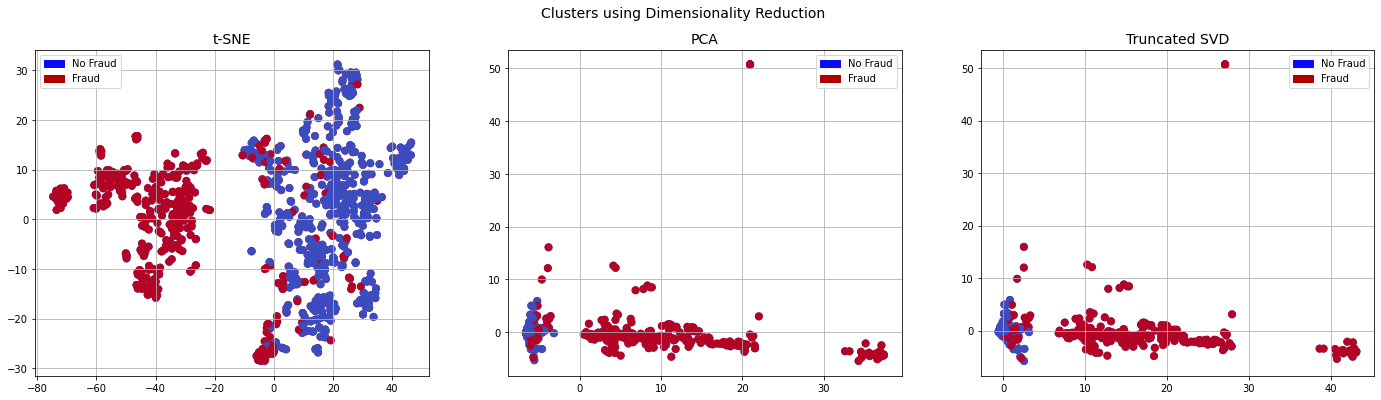

In [80]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud') # matplotlib patches : (x, y, width, height)의 형태로 주어진 튜플의 리스트를 도형으로 시각화
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## 3.4. Classifiers
4개 classifier를 학습해서, 어떤 게 사기거래 감지에 가장 효과적인지 성능을 비교해보려 함<br>
```
The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
```
    - Logistic Regression classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
    (GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers)


##### Logistic Regression / KNearest / SupportVectorClassifier / DecisionTreeClassifier

In [81]:
# 교차검증 하기 전에 다시 Undersampling
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [82]:
# 앞에서 amount/time 데이터 scaling 완료 했으므로, train/test 데이터로 나눠줌
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# 분류 알고리즘에 넣어주기 위해, dataframe -> array 형태로 변환해줌
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [84]:
# 인자 설정 없이 classifier 선언해줌
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [85]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5) # 분류 문제이기 때문에, 기본적으로 accuracy 
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 88.0 % accuracy score


1. classifiers['LogisiticRegression'].__class__ : sklearn.linear_model._logistic.LogisticRegression<br>
2. classifiers['LogisiticRegression'].__class__.__name__ : LogisticRegression

LogisticRegression<br>
feature X 와 Class Y 간 상관성을 클래스의 대표벡터인 coefficients에 학습하여 저장함. <br>
이 때, coefficients vector 가 sparse vector 가 되도록 유도함으로써 classification 에 중요한 몇 개의 features 만을 이용하도록 강제할 수 있습니다. 이를 L1 regularization 혹은 LASSO model 이라 부름
```
formula = ŷ = w[0] * x[0] + w[1] * x[1] + … + w[p] * x[p] + b > 0 
선형회귀와 비슷하지만 가중치(w)합 대신, 예측한 값을 critical value 0 과 비교하여 사용 
=>  0보다 작으면 -1, 0보다 크면 +1로 예측
```

참고. 
LinearSVC와 LogisticRegression은 모두 L2 Regularization(0으로 근사)를 사용함.<br>
Parameter C : Regularization의 강도를 결정<BR>
Parameter penalty : Regularization에서 모든 특성을 이용할지 일부 특성만을 사용할지 결정<br>



```
1. C값이 작을수록 계수를 0으로 근사, regularization이 강화됨
2. Regularization이 강할수록 decision boundary가 수평적으로 그려짐
    cf. C값이 클수록 boundary가 train data에 비슷하게 그려짐 (overfitting 가능성 증가)
```
[Logistic Regression 전반적인 설명 참고](https://woolulu.tistory.com/22)<br>
[L1, L2 Regularization이란? ](https://lovit.github.io/nlp/machine%20learning/2018/03/24/lasso_keyword/)

KNearest<br>
1. Brute force 알고리즘 
데이터셋의 모든 점의 쌍 사이에서의 거리를 모두 계산을 진행함<BR> - NN 알고리즘 중 가장 빠르지만, 데이터셋 사이즈가 크면 비효율적<BR>
2. KD tree 알고리즘
다양한 트리 기반의 데이터 구조를 만드는 것(A와 B가 가깝고 B와 C가 가까우면 A와 C도 가깝다는 논리구조)<br> - Brute force의 데이터 사이즈에 대한 한계를 보완했으나, 얘도 20차원이 넘어가면 비효율적<br>
3. Ball tree 알고리즘
축으로 구분하는 KD Tree와 달리, Ball Tree는 Nesting hyper-spheres로 데이터를 구분하여 높은 차원의 데이터셋을 구분하는데 더 효율적 (물론 비용의 문제는 있음).<br>
<img src = 'https://velog.velcdn.com/images%2Fguri_coding%2Fpost%2F98021073-c8f8-4260-950c-4ce97cf8f594%2FNN%20%E1%84%8B%E1%85%A1%E1%86%AF%E1%84%80%E1%85%A9%E1%84%85%E1%85%B5%E1%84%8C%E1%85%B3%E1%86%B7%20%E1%84%89%E1%85%A5%E1%86%AB%E1%84%90%E1%85%A2%E1%86%A8%20%E1%84%80%E1%85%B5%E1%84%8C%E1%85%AE%E1%86%AB.png'><br>
[KNearest 알고리즘 정리](https://velog.io/@guri_coding/ML-Nearest-Neighbors-%EA%B3%B5%EB%B6%80%ED%95%98%EA%B8%B0)

커널 SVM
선형 SVM으로 분류하기 어려운 형태의 데이터를, 높은 차원으로 이동시켜 고차원 공간에서 데이터를 분류함.<BR>
<IMG SRC = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdU86VP%2FbtqRxZi3Vz9%2FNpj9OAqlZ1QU7u6SnfXTBK%2Fimg.png'><BR>
[사진 출처](https://icefree.tistory.com/entry/Machine-Learning-Kernel-SVMSupport-Vector-Machine)<BR>
[선형/커널 SVM](https://bskyvision.com/163)

In [86]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# KNearest
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], 
               "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [87]:
# Overfitting Case
# 베스트 모델 기준, 교차검증 스코어 계산
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.06%
Knears Neighbors Cross Validation Score 92.22%
Support Vector Classifier Cross Validation Score 92.5%
DecisionTree Classifier Cross Validation Score 91.11%


In [88]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

# sss = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
# 데이터프레임 > 배열로 형태 바꿔줌
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Undersampling 결과 분포 확인하기 위해 Nearmiss 방법 써줌 (이거 variable 안 쓸 거임)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# 사용할 교차검증
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 50608  51264  51337 ... 284804 284805 284806] Test: [    0     1     2 ... 56972 56973 56974]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 50608  51264  51337 ... 113924 113925 113926]
Train: [     0      1      2 ... 284804 284805 284806] Test: [110939 112400 113069 ... 170882 171793 171888]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170883 170884 170885 ... 227844 227845 227846]
Train: [     0      1      2 ... 227844 227845 227846] Test: [227042 227847 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [89]:
# LogisticRegression Learning Curve 시각화
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, 
                        X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # 첫번쨰 Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 두 점 사이 공간 채워줌
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

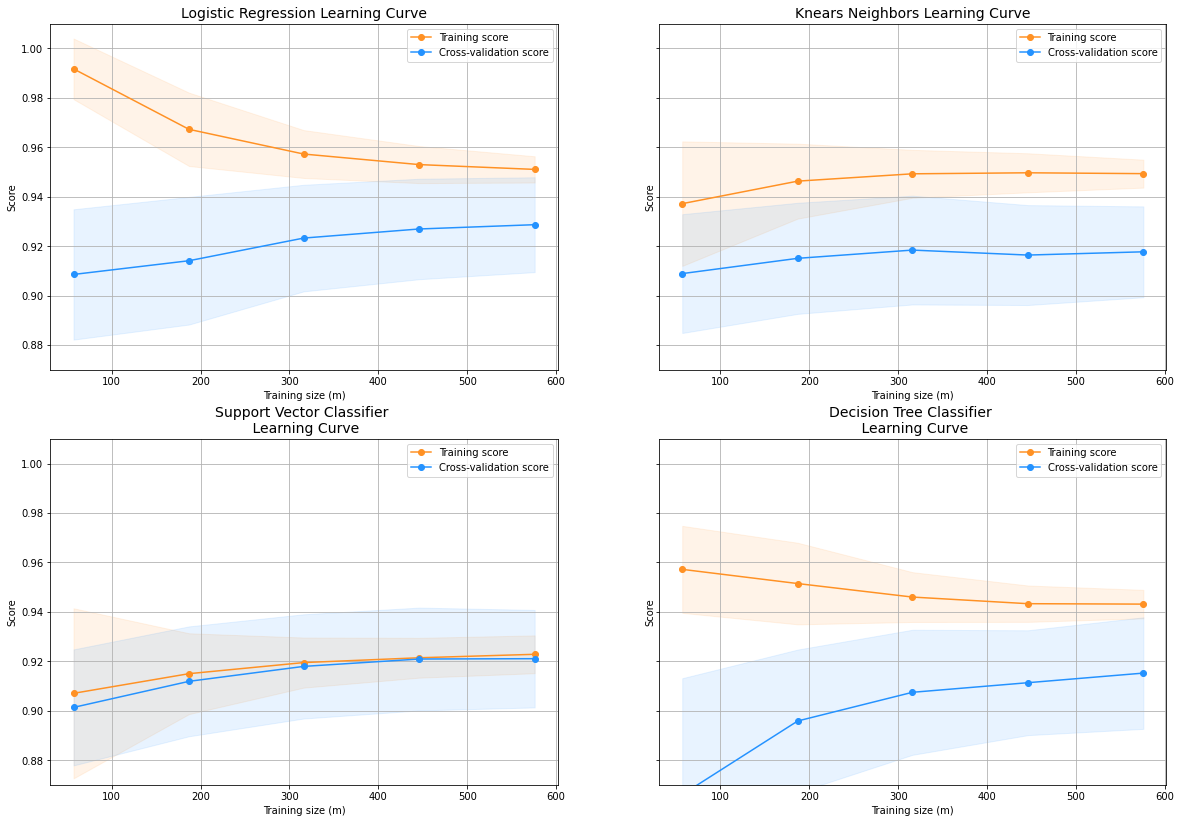

In [90]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [91]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [92]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9645286421691711
KNears Neighbors:  0.9180264150063355
Support Vector Classifier:  0.9776584084142446
Decision Tree Classifier:  0.9110767341164032


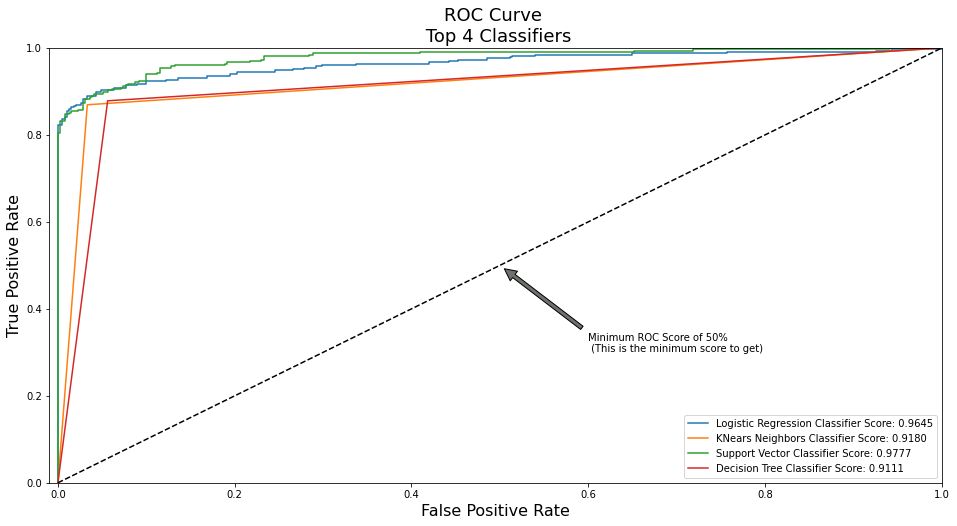

In [93]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## 3.5. A Deeper Look into Logistic Regression

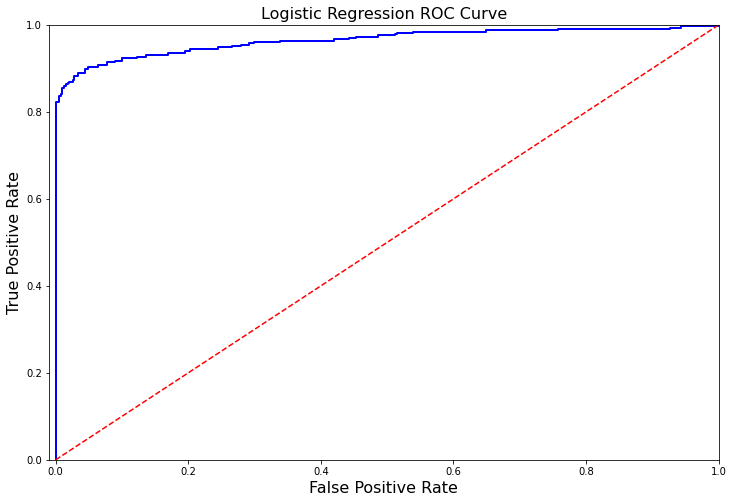

In [94]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [95]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [96]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.96
Precision Score: 0.68
F1 Score: 0.80
Accuracy Score: 0.78
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.59
Precision Score: 0.00
Recall Score: 0.36
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [97]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [98]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))   

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

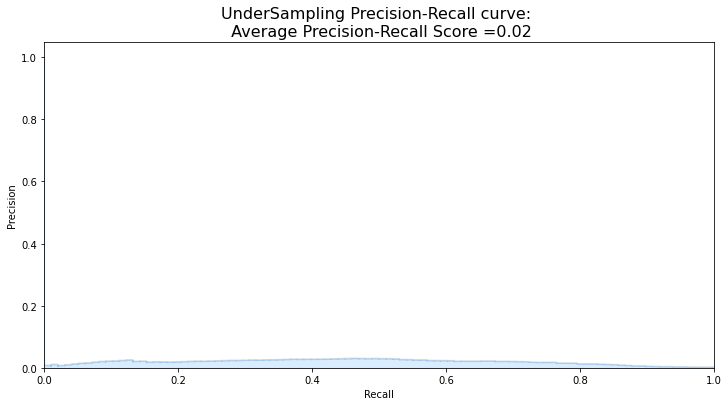

In [99]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## 3.6. Oversampling with SMOTE

if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. In the following section you will see amazing precision and recall scores but in reality our data is overfitting!

The wrong way
<img src= 'https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401'>

The right way
<img src = 'https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372'>

In [100]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9426461250579818
precision: 0.06130028421090798
recall: 0.9137293086660175
f1: 0.11304034916656622
---------------------------------------------------------------------------------------------------------------------------------------


In [101]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [102]:
y_score = best_est.decision_function(original_Xtest)

In [103]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.74')

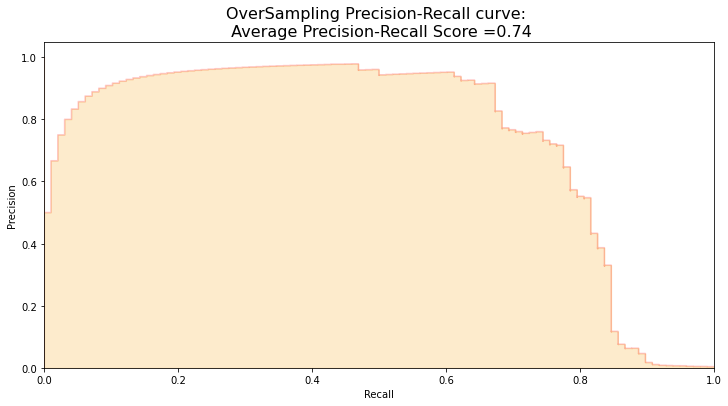

In [104]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [106]:
SMOTE?

In [108]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

# 4. Modeling and Classifying
1. Testing with Logistic Regression
2. Testing with Neural Networks (Undersampling vs Oversampling)



결론 우선 요약<br>
1. Random UnderSampling: We will evaluate the final performance of the classification models in the random undersampling subset. Keep in mind that this is not the data from the original dataframe.
2. Classification Models: The models that performed the best were logistic regression and support vector classifier (SVM)

## 4.1. Testing with Logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

## 4.2. Testing with Neural Networks (Undersampling vs Oversampling)

### Undersampling

### Oversampling

# 5. 결론